<h2>CS 4780/5780 Final Project: </h2>
<h3>COVID-19 Hospitalizations Prediction for EU Countries</h3>

Names and NetIDs for your group members:

<h3>Introduction:</h3>

<p> The final project is about conducting a real-world machine learning project on your own, with everything that is involved. Unlike in the programming projects 1-5, where we gave you all the scaffolding and you just filled in the blanks, you now start from scratch. The programming project provide templates for how to do this, and the most recent video lectures summarize some of the tricks you will need (e.g. feature normalization, feature construction). So, this final project brings realism to how you will use machine learning in the real world.  </p>

The task you will work on is predicting hospitalizations due to COVID-19. Although hospitalizations are directly related to COVID-19 cases, the different populations, timelines and reactionary measures of different EU countries result in different trends in hospitalization numbers. In this project you will bring the power of machine learning to make predictions for the country-level hospitalizations using COVID-19 age group case data and also previous hospitalization data. There will be two tasks, one will be a basic problem that will require you to use methods learned in class. The second task will be more difficult and will require some additional intuition and insight. <b>Please read the project description PDF file carefully and follow the instructions there. Also make sure you write your code and answers to all the questions in this Jupyter Notebook </b> </p>
<p>


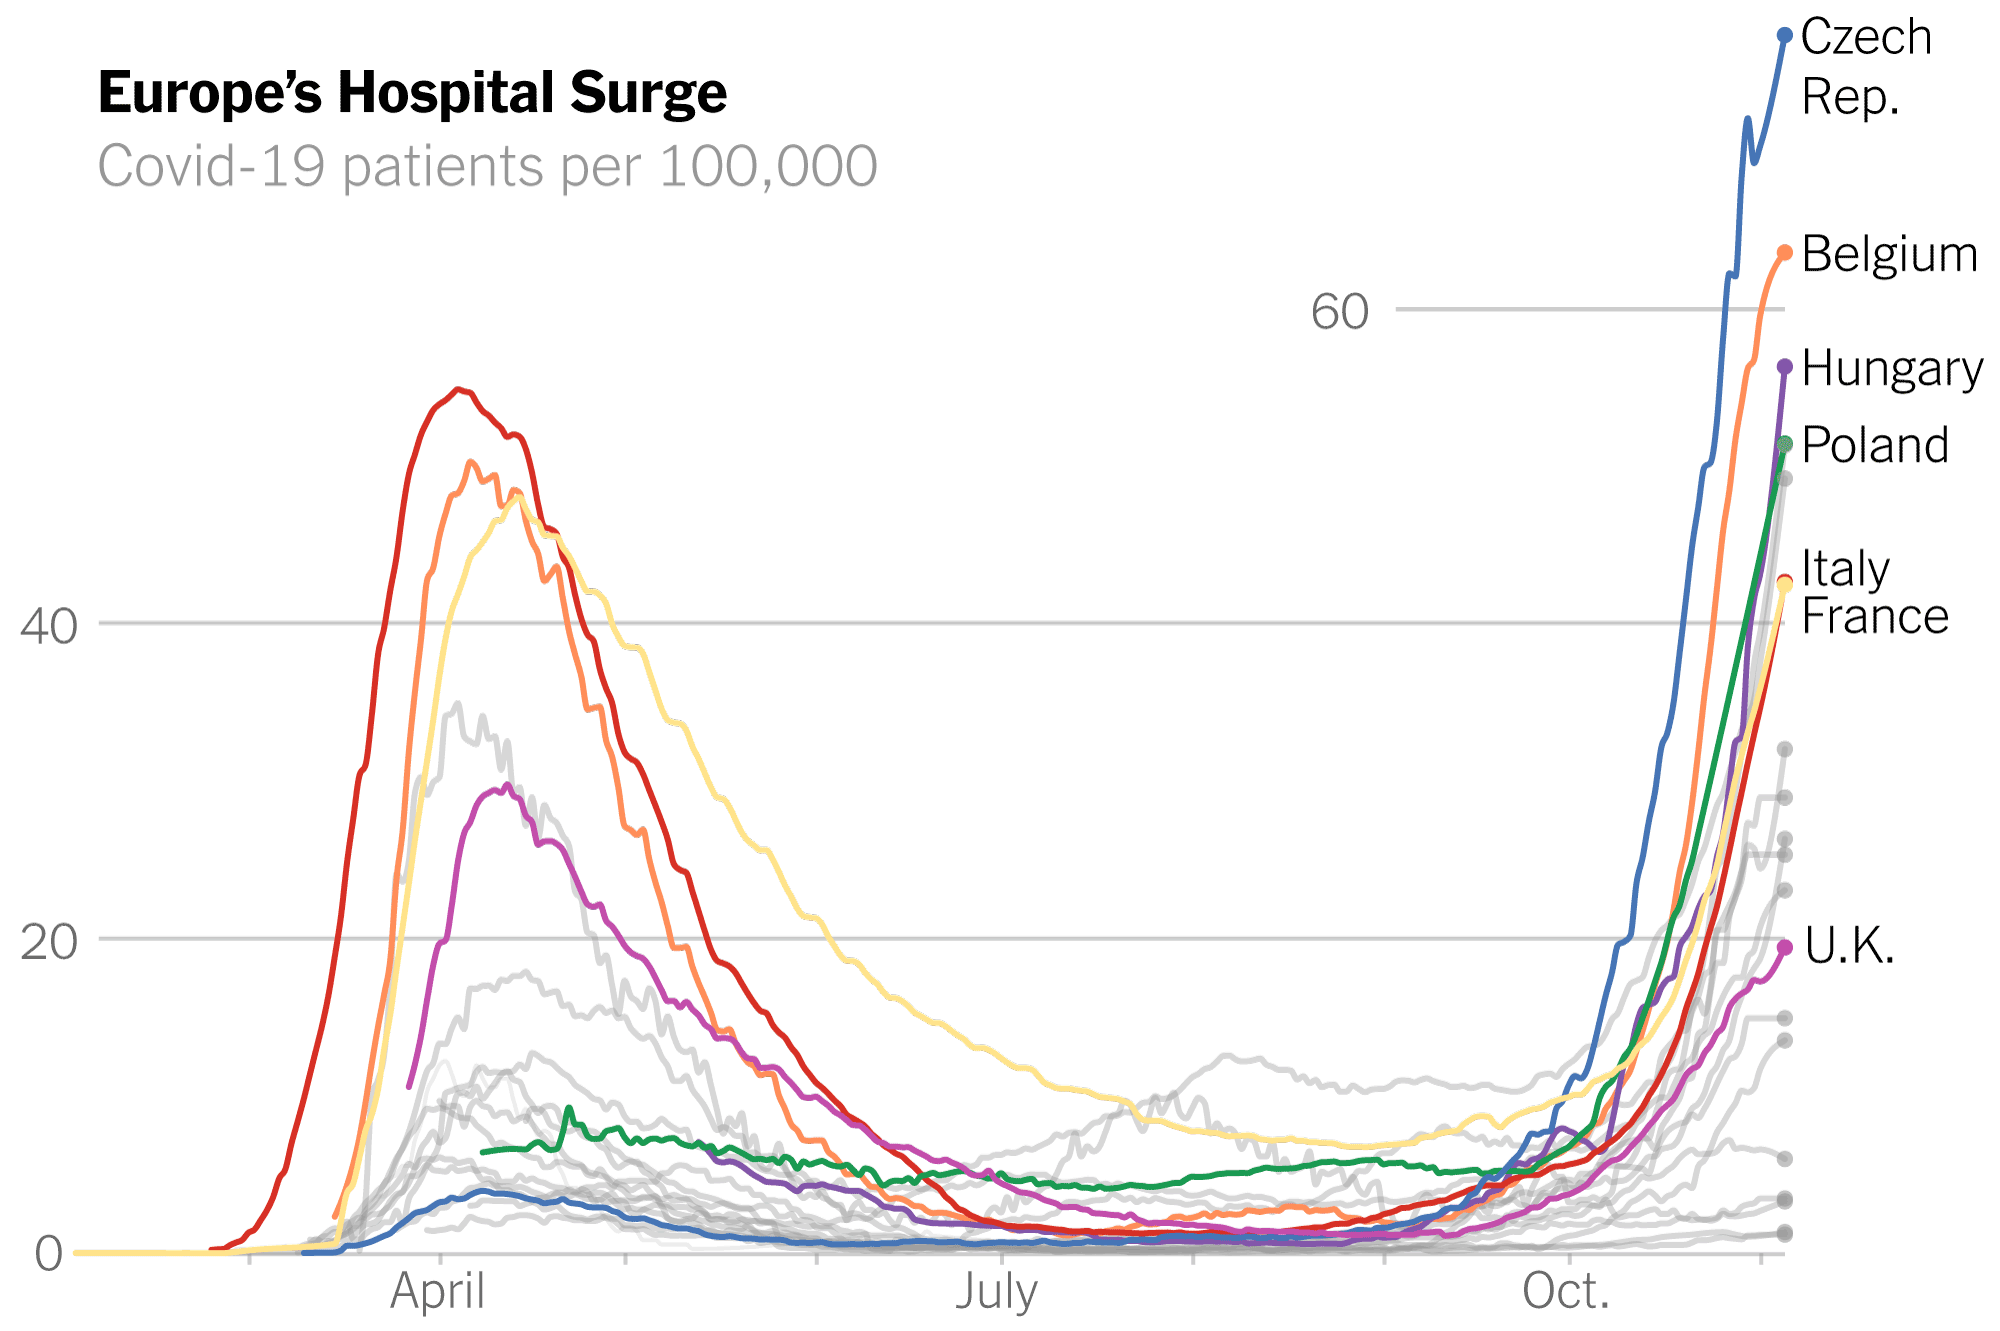

<h2>Part 1: Basics</h2><p>

<h3>1.1 Import:</h3><p>
Please import necessary packages to use. Note that learning and using packages are recommended but not required for this project. Some official tutorial for suggested packacges includes:
    
https://scikit-learn.org/stable/tutorial/basic/tutorial.html
    
https://pytorch.org/tutorials/
    
https://pandas.pydata.org/pandas-docs/stable/user_guide/10min.html
<p>

In [1]:
import os
import pandas as pd
import numpy as np
# TODO
import tensorflow as tf
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

print(tf.__version__)
%matplotlib widget

2.2.0


<h3>1.2 Accuracy and Mean Squared Error:</h3><p>
To measure your performance in the Kaggle Competition, we are using accuracy and mean squared error (MSE). As a recap, accuracy is the percent of labels you predict correctly and MSE is the average squared difference between the estimated values and the actual value. To measure this, you can use library functions from sklearn. A simple example is shown below. 
<p>

In [2]:
from sklearn.metrics import accuracy_score
y_pred = [3, 2, 1, 0, 1, 2, 3]
y_true = [0, 1, 2, 3, 1, 2, 3]
accuracy_score(y_true, y_pred)

0.42857142857142855

In [3]:
from sklearn.metrics import mean_squared_error
mean_squared_error(y_true, y_pred)

2.857142857142857

<h2>Part 2: Baseline Solution</h2><p>
Note that your code should be commented well and in part 2.4 you can refer to your comments.

<h3>2.1 Preprocessing and Feature Extraction:</h3><p>
Given the training dataset and graph information, you need to correctly preprocess the dataset (e.g. feature normalization). Think of what modifications can be done to the data to make it more easily interpretable.
<p>

In [87]:
# You may change this but we suggest loading data with the following code and you may need to change
# datatypes and do necessary data transformation after loading the raw data to the dataframe.
# df = pd.read_csv(dataset_path, sep=',',header=None, encoding='unicode_escape')

# Make sure you comment your code clearly and you may refer to these comments in the part 2.4
# TODO

def load_and_preprocess_data(data_path, t_data_path, predict_path, t_predict_path, t_values = 0):
    def common_preprocess(data, t_data, epoch):
        
        for i in range(1,t_values+1):
            data['value_t-'+str(i)] = data['Daily hospital occupancy'] - t_data['value_t-'+str(i)]
        
        data = data.rename(columns={'Daily hospital occupancy': 'daily_hospital_occupancy'})
    
        data['date'] = pd.to_datetime(data['date'])
        print(epoch)
        data['date_encoding'] = (data['date']-epoch).dt.days
        data = data.drop(['date'], axis=1)
        data = data.drop(['year_week'], axis=1)
        
        return data
    
    data = pd.read_csv(data_path)
    t_data = pd.read_csv(t_data_path)
    epoch = pd.to_datetime(data['date']).min()
    
    df = common_preprocess(data, t_data, epoch)
    predict_data = pd.read_csv(predict_path)
    index = predict_data['country'] + ' ' + predict_data['date']
    t_predict_data = pd.read_csv(t_predict_path)
    predict_df = common_preprocess(predict_data, t_predict_data, epoch)
    
    return index, df, predict_df

In [96]:
t_values = 14
index, df, pdf = load_and_preprocess_data('train_creative.csv', 'train_creative_t_values.csv', 'test_creative_no_label.csv', 'test_creative_t_values.csv', t_values)

CATEGORICAL_COLUMNS = df.columns[0:1].to_numpy().astype('object').tolist()
NUMERIC_COLUMNS = df.columns[1:].to_numpy().tolist()
NUMERIC_COLUMNS.remove('next_week_hospitalizations')

2020-02-12 00:00:00
2020-02-12 00:00:00


In [97]:
scaler = StandardScaler()
df[NUMERIC_COLUMNS] = scaler.fit_transform(df[NUMERIC_COLUMNS])
pdf[NUMERIC_COLUMNS] = scaler.transform(pdf[NUMERIC_COLUMNS])

In [98]:
data = df[CATEGORICAL_COLUMNS + NUMERIC_COLUMNS]
pdata = pdf[CATEGORICAL_COLUMNS + NUMERIC_COLUMNS]

In [99]:
y = df['next_week_hospitalizations']
# mean_y = y.mean()
# std_y = y.std()
# y = (y - mean_y)/std_y

In [100]:
data

,country,daily_hospital_occupancy,under_15_cases,15-24_cases,25-49_cases,50-64_cases,65-79_cases,over_80_cases,value_t-1,value_t-2,...,value_t-6,value_t-7,value_t-8,value_t-9,value_t-10,value_t-11,value_t-12,value_t-13,value_t-14,date_encoding
0,Belgium,-0.351214,-0.369019,-0.427223,-0.424536,-0.401582,-0.403804,-0.409997,1.046794,0.549160,...,0.151643,0.119627,0.095151,0.075769,0.059728,0.046366,0.034817,0.025204,0.016611,-1.536252
1,Belgium,-0.332702,-0.367305,-0.419764,-0.392884,-0.375323,-0.364444,-0.346989,0.392164,0.798129,...,0.244023,0.199874,0.166195,0.139702,0.118010,0.100031,0.084702,0.071993,0.060765,-1.527243
2,Belgium,-0.311422,-0.367305,-0.419764,-0.392884,-0.375323,-0.364444,-0.346989,0.459305,0.472375,...,0.350218,0.292121,0.247862,0.213196,0.185007,0.161720,0.142047,0.125779,0.111522,-1.518234
3,Belgium,-0.284951,-0.367305,-0.419764,-0.392884,-0.375323,-0.364444,-0.346989,0.585196,0.579408,...,0.482314,0.406866,0.349447,0.304615,0.268346,0.238455,0.213378,0.192684,0.174658,-1.509225
4,Belgium,-0.251387,-0.367305,-0.419764,-0.392884,-0.375323,-0.364444,-0.346989,0.757246,0.744613,...,0.649808,0.552360,0.478255,0.420532,0.374016,0.335753,0.303825,0.277517,0.254712,-1.500216
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3980,Spain,2.425800,1.800035,0.944441,0.862060,0.654951,0.626430,0.484399,-4.022398,-4.735047,...,-6.279613,-6.457610,-6.577620,-6.907935,-6.768019,-6.586459,-6.587811,-6.563344,-6.574289,1.535888
3981,Spain,2.234448,1.256557,0.685622,0.599388,0.444623,0.409565,0.228008,-4.698011,-4.835100,...,-6.207953,-6.296367,-6.462091,-6.590060,-6.909095,-6.795098,-6.646554,-6.670041,-6.657233,1.562916
3982,Spain,1.938079,1.256557,0.685622,0.599388,0.444623,0.409565,0.228008,-7.245196,-6.622098,...,-6.580930,-6.689351,-6.722363,-6.848782,-6.949947,-7.229429,-7.123496,-6.990570,-7.008401,1.580934
3983,Spain,1.823199,1.256557,0.685622,0.599388,0.444623,0.409565,0.228008,-2.843223,-5.593643,...,-5.915270,-6.226620,-6.373785,-6.456217,-6.614415,-6.740932,-7.038178,-6.979200,-6.878002,1.589944


In [101]:
seed = 42

train_ratio = 0.7
validation_ratio = 0.15
test_ratio = 0.15

x_train, x_test, y_train, y_test = train_test_split(data, y, test_size = 1 - train_ratio, random_state = seed)

x_val, x_test, y_val, y_test = train_test_split(x_test, y_test, test_size=test_ratio/(test_ratio + validation_ratio), random_state = seed) 

<h3>2.2 Use At Least Two Training Algorithms from class:</h3><p>
You need to use at least two training algorithms from class. You can use your code from previous projects or any packages you imported in part 1.1.

In [102]:
# Make sure you comment your code clearly and you may refer to these comments in the part 2.4
# TODO
def create_tf_df(df, labels, shuffle = True, batch_size = 32):
    ds = tf.data.Dataset.from_tensor_slices((dict(df), labels))
    if shuffle:
        ds = ds.shuffle(buffer_size = len(df))
    ds = ds.batch(batch_size)
    return ds

def create_pdf(df, batch_size = 1):
    ds = tf.data.Dataset.from_tensor_slices(dict(pdf))
    ds = ds.batch(batch_size)
    return ds
    
batch_size = 32

train_df = create_tf_df(x_train, y_train, shuffle = False, batch_size = batch_size)
val_df = create_tf_df(x_val, y_val, shuffle = False, batch_size = batch_size)
test_df = create_tf_df(x_test, y_test, shuffle = False, batch_size = batch_size)
full_df = create_tf_df(data, y, shuffle = False, batch_size = batch_size)
pdf_df = create_pdf(pdf)

In [103]:
feature_columns = []

for feature_name in CATEGORICAL_COLUMNS:
    vocabulary = data[feature_name].unique()
    feature_columns.append(tf.feature_column.indicator_column(tf.feature_column.categorical_column_with_vocabulary_list(feature_name, vocabulary)))

for feature_name in NUMERIC_COLUMNS:
    feature_columns.append(tf.feature_column.numeric_column(feature_name, dtype = tf.float64))

feature_layer = tf.keras.layers.DenseFeatures(feature_columns)

In [118]:
initial_lr = 0.001

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_lr,
    decay_steps = 10000,
    decay_rate = 0.96,
    staircase = True)

from tensorflow.keras import optimizers

    
model = tf.keras.Sequential([
    feature_layer,
    tf.keras.layers.Dense(15, activation = 'relu', kernel_regularizer = tf.keras.regularizers.l1_l2(l1=0.1, l2=0.01)),
    tf.keras.layers.Dense(15, activation = 'relu', kernel_regularizer = tf.keras.regularizers.l1_l2(l1=0.1, l2=0.01)),
    tf.keras.layers.Dense(15, activation = 'relu', kernel_regularizer = tf.keras.regularizers.l1_l2(l1=0.1, l2=0.01)),
    tf.keras.layers.Dense(1)
])
    
optimizer = tf.optimizers.RMSprop(learning_rate = lr_schedule)

model.compile(loss = 'mse',
              optimizer = optimizer,
              metrics=['mse'])

In [119]:
history = model.fit(train_df, validation_data = val_df, epochs = 350)

Epoch 1/350
88/88 [==============================] - 1s 7ms/step - loss: 41433720.0000 - mse: 41433704.0000 - val_loss: 37683680.0000 - val_mse: 37683664.0000
Epoch 2/350
88/88 [==============================] - 0s 5ms/step - loss: 41367192.0000 - mse: 41367176.0000 - val_loss: 37550472.0000 - val_mse: 37550452.0000
Epoch 3/350
88/88 [==============================] - 0s 5ms/step - loss: 41126816.0000 - mse: 41126796.0000 - val_loss: 37152124.0000 - val_mse: 37152092.0000
Epoch 4/350
88/88 [==============================] - 0s 5ms/step - loss: 40479648.0000 - mse: 40479628.0000 - val_loss: 36232252.0000 - val_mse: 36232228.0000
Epoch 5/350
88/88 [==============================] - 0s 6ms/step - loss: 39075272.0000 - mse: 39075248.0000 - val_loss: 34466804.0000 - val_mse: 34466780.0000
Epoch 6/350
88/88 [==============================] - 1s 6ms/step - loss: 36523208.0000 - mse: 36523180.0000 - val_loss: 31516022.0000 - val_mse: 31515988.0000
Epoch 7/350
88/88 [===========================

In [121]:
history = model.fit(train_df, validation_data = val_df, epochs = 100)

Epoch 1/100
88/88 [==============================] - 0s 5ms/step - loss: 178171.8281 - mse: 178099.0156 - val_loss: 186206.1250 - val_mse: 186133.3438
Epoch 2/100
88/88 [==============================] - 1s 6ms/step - loss: 177992.0312 - mse: 177919.2656 - val_loss: 185627.7656 - val_mse: 185554.9062
Epoch 3/100
88/88 [==============================] - 1s 6ms/step - loss: 177798.0625 - mse: 177725.1719 - val_loss: 184847.5781 - val_mse: 184774.7188
Epoch 4/100
88/88 [==============================] - 0s 5ms/step - loss: 177601.4531 - mse: 177528.5312 - val_loss: 185207.2344 - val_mse: 185134.2656
Epoch 5/100
88/88 [==============================] - 0s 6ms/step - loss: 177380.3906 - mse: 177307.3750 - val_loss: 185753.3438 - val_mse: 185680.3438
Epoch 6/100
88/88 [==============================] - 0s 6ms/step - loss: 177392.8281 - mse: 177319.8594 - val_loss: 185930.1250 - val_mse: 185857.0625
Epoch 7/100
88/88 [==============================] - 1s 7ms/step - loss: 176922.1719 - mse: 17

In [120]:
print(history.history.keys())
#  "Accuracy"
plt.figure()
plt.plot(history.history['mse'])
plt.plot(history.history['val_mse'])
plt.title('model mean squared error')
plt.ylabel('mse')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

dict_keys(['loss', 'mse', 'val_loss', 'val_mse'])


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [123]:
model.evaluate(test_df)

19/19 [==============================] - 0s 2ms/step - loss: 221997.6094 - mse: 221919.4844


[221997.609375, 221919.484375]

# Training on Full dataset

In [124]:
history = model.fit(full_df, validation_data = val_df, epochs = 400)

Epoch 1/400
125/125 [==============================] - 1s 6ms/step - loss: 185280.8906 - mse: 185202.7500 - val_loss: 168983.2188 - val_mse: 168905.1562
Epoch 2/400
125/125 [==============================] - 1s 7ms/step - loss: 182659.0781 - mse: 182581.0938 - val_loss: 166306.6875 - val_mse: 166228.7656
Epoch 3/400
125/125 [==============================] - 1s 5ms/step - loss: 182779.1562 - mse: 182701.3125 - val_loss: 165809.7969 - val_mse: 165731.9531
Epoch 4/400
125/125 [==============================] - 1s 5ms/step - loss: 182397.3281 - mse: 182319.5781 - val_loss: 166049.6094 - val_mse: 165971.8281
Epoch 5/400
125/125 [==============================] - 1s 7ms/step - loss: 182442.7031 - mse: 182364.9844 - val_loss: 166033.1562 - val_mse: 165955.3906
Epoch 6/400
125/125 [==============================] - 1s 7ms/step - loss: 182658.8594 - mse: 182581.1250 - val_loss: 166278.6875 - val_mse: 166200.9531
Epoch 7/400
125/125 [==============================] - 1s 7ms/step - loss: 182829.

In [92]:
initial_lr = 0.01

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_lr,
    decay_steps = 10000,
    decay_rate = 0.96,
    staircase = True)

from tensorflow.keras import optimizers

    
model = tf.keras.Sequential([
    feature_layer,
    tf.keras.layers.Dense(20, activation = 'relu', kernel_regularizer = tf.keras.regularizers.l1_l2(l1=0.1, l2=0.01)),
    tf.keras.layers.Dense(20, activation = 'relu', kernel_regularizer = tf.keras.regularizers.l1_l2(l1=0.1, l2=0.01)),
    tf.keras.layers.Dense(20, activation = 'relu', kernel_regularizer = tf.keras.regularizers.l1_l2(l1=0.1, l2=0.01)),
    tf.keras.layers.Dense(1)
])
    
optimizer = tf.optimizers.RMSprop(learning_rate = lr_schedule)

model.compile(loss = 'mse',
              optimizer = optimizer,
              metrics=['mse'])

history = model.fit(full_df, validation_data = val_df, epochs = 400)

Epoch 1/400
125/125 [==============================] - 1s 6ms/step - loss: 29006300.0000 - mse: 29006262.0000 - val_loss: 13111638.0000 - val_mse: 13111593.0000
Epoch 2/400
125/125 [==============================] - 0s 3ms/step - loss: 8318156.5000 - mse: 8318107.5000 - val_loss: 5756876.0000 - val_mse: 5756823.5000
Epoch 3/400
125/125 [==============================] - 0s 3ms/step - loss: 5980935.0000 - mse: 5980881.5000 - val_loss: 4348569.0000 - val_mse: 4348513.5000
Epoch 4/400
125/125 [==============================] - 0s 3ms/step - loss: 4656282.5000 - mse: 4656225.5000 - val_loss: 3189911.7500 - val_mse: 3189855.5000
Epoch 5/400
125/125 [==============================] - 0s 3ms/step - loss: 3763516.0000 - mse: 3763457.2500 - val_loss: 2366891.5000 - val_mse: 2366833.5000
Epoch 6/400
125/125 [==============================] - 0s 3ms/step - loss: 3191544.2500 - mse: 3191485.2500 - val_loss: 1766509.5000 - val_mse: 1766449.5000
Epoch 7/400
125/125 [==============================] -

In [75]:
history = model.fit(full_df, validation_data = val_df, epochs = 500)

Epoch 1/500
125/125 [==============================] - 1s 5ms/step - loss: 570230.8125 - mse: 570146.3750 - val_loss: 402808.4375 - val_mse: 402723.8438
Epoch 2/500
125/125 [==============================] - 1s 6ms/step - loss: 569573.1250 - mse: 569488.6875 - val_loss: 403007.5312 - val_mse: 402922.9375
Epoch 3/500
125/125 [==============================] - 1s 5ms/step - loss: 569754.1875 - mse: 569669.6875 - val_loss: 402344.7812 - val_mse: 402260.1875
Epoch 4/500
125/125 [==============================] - 1s 5ms/step - loss: 569247.6250 - mse: 569163.0625 - val_loss: 401959.7188 - val_mse: 401875.1250
Epoch 5/500
125/125 [==============================] - 1s 6ms/step - loss: 568887.0625 - mse: 568802.3125 - val_loss: 401712.0938 - val_mse: 401627.2812
Epoch 6/500
125/125 [==============================] - 1s 5ms/step - loss: 568255.2500 - mse: 568170.4375 - val_loss: 402149.7812 - val_mse: 402064.9688
Epoch 7/500
125/125 [==============================] - 1s 6ms/step - loss: 568488.

In [93]:
print(history.history.keys())
#  "Accuracy"
plt.figure()
plt.plot(history.history['mse'])
plt.plot(history.history['val_mse'])
plt.title('model mean squared error')
plt.ylabel('mse')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

dict_keys(['loss', 'mse', 'val_loss', 'val_mse'])


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [122]:
pred = model.predict(pdf_df)
# pred = pred * std_y + mean_y
# y = np.where(y > 0.5, 1, 0)
submit = {'country_id': index, 'next_week_hospitalizations':pred.astype(int).flatten()}
sdf = pd.DataFrame(data = submit)
sdf.to_csv('submit.csv',index = False)

In [ ]:
# initial_lr = 0.001

# lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
#     initial_lr,
#     decay_steps = 10000,
#     decay_rate = 0.96,
#     staircase = True)

# from tensorflow.keras import optimizers

    
# model = tf.keras.Sequential([
#     feature_layer,
#     tf.keras.layers.Dense(20, activation = 'relu', kernel_regularizer = tf.keras.regularizers.l1_l2(l1=0.1, l2=0.01)),
#     tf.keras.layers.Dense(20, activation = 'relu', kernel_regularizer = tf.keras.regularizers.l1_l2(l1=0.1, l2=0.01)),
#     tf.keras.layers.Dense(20, activation = 'relu', kernel_regularizer = tf.keras.regularizers.l1_l2(l1=0.1, l2=0.01)),
#     tf.keras.layers.Dense(1)
# ])
    
# optimizer = tf.optimizers.RMSprop(learning_rate = lr_schedule)

# model.compile(loss = 'mse',
#               optimizer = optimizer,
#               metrics=['mse'])

# history = model.fit(full_df, validation_data = val_df, epochs = 300)

# 188986 - 7 t_values, new date encoding, change t_values to increase

<h3>2.3 Training, Validation and Model Selection:</h3><p>
You need to split your data to a training set and validation set or performing a cross-validation for model selection.

In [5]:
# Make sure you comment your code clearly and you may refer to these comments in the part 2.4
# TODO

<h3>2.4 Explanation in Words:</h3><p>
    You need to answer the following questions in the markdown cell after this cell:

2.4.1 How did you preprocess the dataset and features, and how did you formulate the learning problem (or problems)?

2.4.2 Which two learning methods from class did you choose and why did you made the choices?

2.4.3 How did you do the model selection?

2.4.4 Does the test performance reach a given baseline 70% performance? (Please include a screenshot of Kaggle Submission)

<h2>Part 3: Creative Solution</h2><p>

<h3>3.1 Open-ended Code:</h3><p>
You may follow the steps in part 2 again but making innovative changes like creating/using new features, using new training algorithms, etc. Make sure you explain everything clearly in part 3.2. Note that reaching the 150k MSE creative baseline is only a small portion of this part. Any creative ideas will receive most points as long as they are reasonable and clearly explained.

In [1]:
# Make sure you comment your code clearly and you may refer to these comments in the part 3.2
# TODO

<h3>3.2 Explanation in Words:</h3><p>

You need to answer the following questions in a markdown cell after this cell:

3.2.1 How much did you manage to improve performance on the test set? Did you reach the 150k MSE for the test in Kaggle? (Please include a screenshot of Kaggle Submission)

3.2.2 Please explain in detail how you achieved this and what you did specifically and why you tried this.

<h2>Part 4: Kaggle Submission</h2><p>
You need to generate a prediction CSV using the following cell from your trained model and submit the direct output of your code to Kaggle. The CSV shall contain TWO columns. The first column should be named "country_id" and be a concatenation of the country and date in the first two columns of the test_no_label.csv. This is because for the Kaggle competition we need a unique identifier for every row. For instance, the first entry should be "Belgium 9/7/2020". The second column of the prediction csv should have the same name as the target metric (either "next_week_increase_decrease" or "next_week_hospitalizations") with your generated predictions. Your file should have 1144 total rows excluding the column names. The order should be the same as in the test_baseline/creative_no_label.csv. A sample predication file can be downloaded from Kaggle for each problem.

In [1]:
# TODO

# You may use pandas to generate a dataframe with country, date and your predictions first 
# and then use to_csv to generate a CSV file.

<h2>Part 5: Resources and Literature Used</h2><p>